In [276]:
import os
import cv2
import numpy as np
from matplotlib.image import imread
import matplotlib.pyplot as plt
import skimage
from skimage import img_as_ubyte
from skimage.color import rgb2gray
from skimage.color import gray2rgb
from skimage.filters import try_all_threshold
from skimage import filters


def getEdges(img):
    horizontalEdges = np.array([[-1,0,-1],[0,0,0],[1,0,1]])
    verticalEdges = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
    horizontalEdgescards = np.zeros(img.shape)
    verticalEdgescards = np.zeros(img.shape)
    for i in range(1, img.shape[0]-1):
        for j in range(1, img.shape[1]-1):
            horizontalEdgescards[i,j] = np.sum(img[i-1:i+2, j-1:j+2]*horizontalEdges)
            verticalEdgescards[i,j] = np.sum(img[i-1:i+2, j-1:j+2]*verticalEdges)

    edges = verticalEdgescards + horizontalEdgescards
    return edges


def median_filter(img_noisy1):
    # Obtain the number of rows and columns
    # of the image
    m, n = img_noisy1.shape
  
    # Traverse the image. For every 3X3 area,
    # find the median of the pixels and
    # replace the center pixel by the median
    img_new1 = np.zeros([m, n])
 
    for i in range(1, m-1):
        for j in range(1, n-1):
            temp = [img_noisy1[i-1, j-1],
                   img_noisy1[i-1, j],
                   img_noisy1[i-1, j + 1],
                   img_noisy1[i, j-1],
                   img_noisy1[i, j],
                   img_noisy1[i, j + 1],
                   img_noisy1[i + 1, j-1],
                   img_noisy1[i + 1, j],
                   img_noisy1[i + 1, j + 1]]

            temp = sorted(temp)
            img_new1[i, j]= temp[4]

    img_new1 = img_new1.astype(np.uint8)
    return img_new1

In [264]:
import numpy as np
import scipy as sp
import scipy.ndimage
import cv2
import matplotlib.pyplot as plt
import imageio

def box(img, r):
    """ O(1) box filter
        img - >= 2d image
        r   - radius of box filter
    """
    (rows, cols) = img.shape[:2]
    imDst = np.zeros_like(img)


    tile = [1] * img.ndim
    tile[0] = r
    imCum = np.cumsum(img, 0)
    imDst[0:r+1, :, ...] = imCum[r:2*r+1, :, ...]
    imDst[r+1:rows-r, :, ...] = imCum[2*r+1:rows, :, ...] - imCum[0:rows-2*r-1, :, ...]
    imDst[rows-r:rows, :, ...] = np.tile(imCum[rows-1:rows, :, ...], tile) - imCum[rows-2*r-1:rows-r-1, :, ...]

    tile = [1] * img.ndim
    tile[1] = r
    imCum = np.cumsum(imDst, 1)
    imDst[:, 0:r+1, ...] = imCum[:, r:2*r+1, ...]
    imDst[:, r+1:cols-r, ...] = imCum[:, 2*r+1 : cols, ...] - imCum[:, 0 : cols-2*r-1, ...]
    imDst[:, cols-r: cols, ...] = np.tile(imCum[:, cols-1:cols, ...], tile) - imCum[:, cols-2*r-1 : cols-r-1, ...]

    return imDst

def _gf_color(I, p, r, eps, s=None):
    """ Color guided filter
    I - guide image (rgb)
    p - filtering input (single channel)
    r - window radius
    eps - regularization (roughly, variance of non-edge noise)
    s - subsampling factor for fast guided filter
    """
    fullI = I
    fullP = p
    if s is not None:
        I = sp.ndimage.zoom(fullI, [1/s, 1/s, 1], order=1)
        p = sp.ndimage.zoom(fullP, [1/s, 1/s], order=1)
        r = round(r / s)

    h, w = p.shape[:2]
    N = box(np.ones((h, w)), r)

    mI_r = box(I[:,:,0], r) / N
    mI_g = box(I[:,:,1], r) / N
    mI_b = box(I[:,:,2], r) / N

    mP = box(p, r) / N

    # mean of I * p
    mIp_r = box(I[:,:,0]*p, r) / N
    mIp_g = box(I[:,:,1]*p, r) / N
    mIp_b = box(I[:,:,2]*p, r) / N

    # per-patch covariance of (I, p)
    covIp_r = mIp_r - mI_r * mP
    covIp_g = mIp_g - mI_g * mP
    covIp_b = mIp_b - mI_b * mP

    # symmetric covariance matrix of I in each patch:
    #       rr rg rb
    #       rg gg gb
    #       rb gb bb
    var_I_rr = box(I[:,:,0] * I[:,:,0], r) / N - mI_r * mI_r;
    var_I_rg = box(I[:,:,0] * I[:,:,1], r) / N - mI_r * mI_g;
    var_I_rb = box(I[:,:,0] * I[:,:,2], r) / N - mI_r * mI_b;

    var_I_gg = box(I[:,:,1] * I[:,:,1], r) / N - mI_g * mI_g;
    var_I_gb = box(I[:,:,1] * I[:,:,2], r) / N - mI_g * mI_b;

    var_I_bb = box(I[:,:,2] * I[:,:,2], r) / N - mI_b * mI_b;

    a = np.zeros((h, w, 3))
    for i in range(h):
        for j in range(w):
            sig = np.array([
                [var_I_rr[i,j], var_I_rg[i,j], var_I_rb[i,j]],
                [var_I_rg[i,j], var_I_gg[i,j], var_I_gb[i,j]],
                [var_I_rb[i,j], var_I_gb[i,j], var_I_bb[i,j]]
            ])
            covIp = np.array([covIp_r[i,j], covIp_g[i,j], covIp_b[i,j]])
            a[i,j,:] = np.linalg.solve(sig + eps * np.eye(3), covIp)

    b = mP - a[:,:,0] * mI_r - a[:,:,1] * mI_g - a[:,:,2] * mI_b

    meanA = box(a, r) / N[...,np.newaxis]
    meanB = box(b, r) / N

    if s is not None:
        meanA = sp.ndimage.zoom(meanA, [s, s, 1], order=1)
        meanB = sp.ndimage.zoom(meanB, [s, s], order=1)

    q = np.sum(meanA * fullI, axis=2) + meanB

    return q


def _gf_gray(I, p, r, eps, s=None):
    """ grayscale (fast) guided filter
        I - guide image (1 channel)
        p - filter input (1 channel)
        r - window raidus
        eps - regularization (roughly, allowable variance of non-edge noise)
        s - subsampling factor for fast guided filter
    """
    if s is not None:
        Isub = sp.ndimage.zoom(I, 1/s, order=1)
        Psub = sp.ndimage.zoom(p, 1/s, order=1)
        r = round(r / s)
    else:
        Isub = I
        Psub = p


    (rows, cols) = Isub.shape

    N = box(np.ones([rows, cols]), r)

    meanI = box(Isub, r) / N
    meanP = box(Psub, r) / N
    corrI = box(Isub * Isub, r) / N
    corrIp = box(Isub * Psub, r) / N
    varI = corrI - meanI * meanI
    covIp = corrIp - meanI * meanP


    a = covIp / (varI + eps)
    b = meanP - a * meanI

    meanA = box(a, r) / N
    meanB = box(b, r) / N

    if s is not None:
        meanA = sp.ndimage.zoom(meanA, s, order=1)
        meanB = sp.ndimage.zoom(meanB, s, order=1)

    q = meanA * I + meanB
    return q


def _gf_colorgray(I, p, r, eps, s=None):
    """ automatically choose color or gray guided filter based on I's shape """
    if I.ndim == 2 or I.shape[2] == 1:
        return _gf_gray(I, p, r, eps, s)
    elif I.ndim == 3 and I.shape[2] == 3:
        return _gf_color(I, p, r, eps, s)
    else:
        print("Invalid guide dimensions:", I.shape)


def guided_filter(I, p, r, eps, s=None):
    """ run a guided filter per-channel on filtering input p
        I - guide image (1 or 3 channel)
        p - filter input (n channel)
        r - window raidus
        eps - regularization (roughly, allowable variance of non-edge noise)
        s - subsampling factor for fast guided filter
    """
    if p.ndim == 2:
        p3 = p[:,:,np.newaxis]

    out = np.zeros_like(p3)
    for ch in range(p3.shape[2]):
        out[:,:,ch] = _gf_colorgray(I, p3[:,:,ch], r, eps, s)
    return np.squeeze(out) if p.ndim == 2 else out


def test_gf(image,eps):
    ''' The image passed should be single channel i.e greyscale and of good quality
        eps to be 0.01 or 0.05
        r to be 8
    '''
    card = image.astype(np.float32) / 255
    r = 8
    card_smoothed = _gf_gray(card, card, r, eps)
    return card_smoothed

In [231]:
img1 = cv2.imread('atash2.jpg',0)
img2 = cv2.imread('zaid.jpeg',0)
img3 = cv2.imread('amar.jpg',0)
img4 = cv2.imread('cnic_smoothed.png',0)

Text(0.5, 1.0, 'ADPT THRESH')

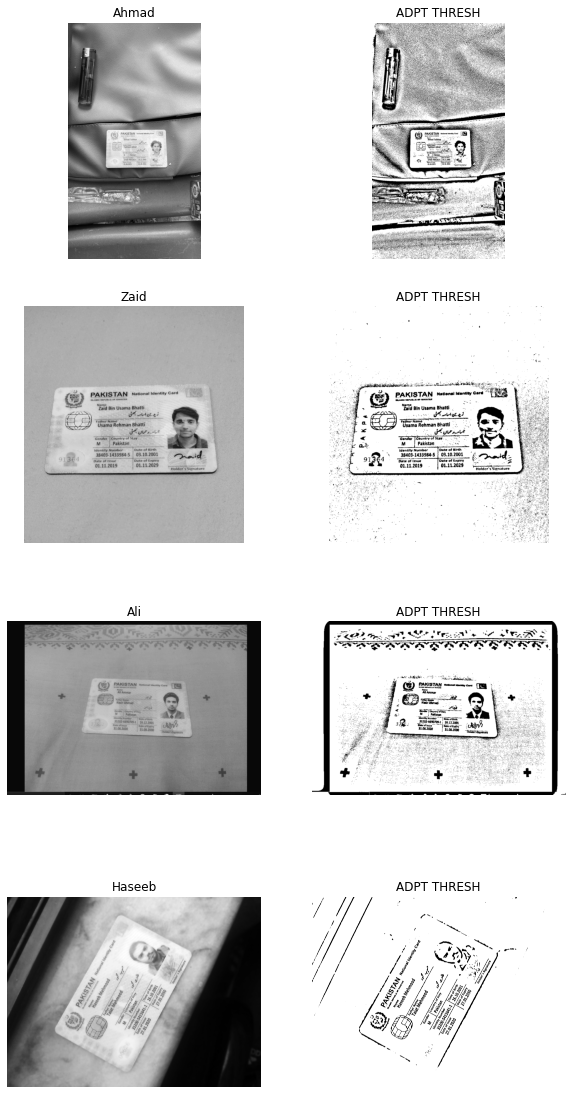

In [232]:
# adaptive thresholding
adp_th1 = cv2.adaptiveThreshold(img1,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,107,9)
adp_th2 = cv2.adaptiveThreshold(img2,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,107,9)
adp_th3 = cv2.adaptiveThreshold(img3,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,107,9)
adp_th4 = cv2.adaptiveThreshold(img4,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,107,9)


fig = plt.figure(figsize=(10, 20))
# setting values to rows and column variables
rows = 4
columns = 2
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(img1,'gray')
plt.axis('off')
plt.title("Ahmad")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(adp_th1,'gray')
plt.axis('off')
plt.title("ADPT THRESH")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(img2,'gray')
plt.axis('off')
plt.title("Zaid")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(adp_th2,'gray')
plt.axis('off')
plt.title("ADPT THRESH")

# Adds a subplot at the 5th position
fig.add_subplot(rows, columns, 5)
  
# showing image
plt.imshow(img3,'gray')
plt.axis('off')
plt.title("Ali")
  
# Adds a subplot at the 6th position
fig.add_subplot(rows, columns, 6)
  
# showing image
plt.imshow(adp_th3,'gray')
plt.axis('off')
plt.title("ADPT THRESH")

# Adds a subplot at the 7th position
fig.add_subplot(rows, columns, 7)
  
# showing image
plt.imshow(img4,'gray')
plt.axis('off')
plt.title("Haseeb")
  
# Adds a subplot at the 8th position
fig.add_subplot(rows, columns, 8)
  
# showing image
plt.imshow(adp_th4,'gray')
plt.axis('off')
plt.title("ADPT THRESH")

Text(0.5, 1.0, 'ADPT THRESH & Bilateral')

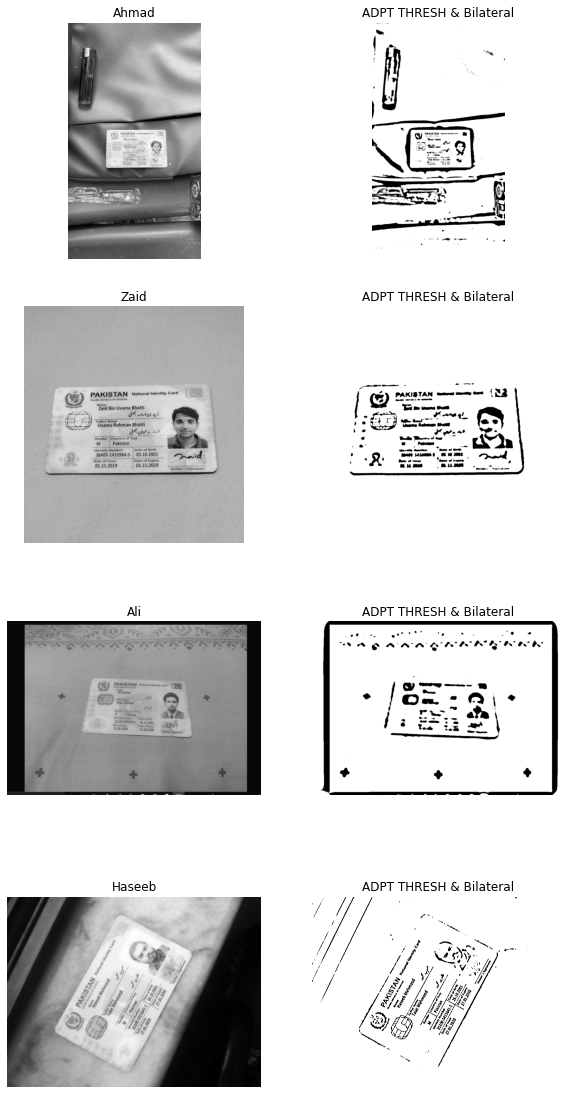

In [243]:
bilateral1 = cv2.bilateralFilter(img1, 15, 75, 75)
bilateral2 = cv2.bilateralFilter(img2, 15, 75, 75)
bilateral3 = cv2.bilateralFilter(img3, 15, 75, 75)
bilateral4 = cv2.bilateralFilter(img4, 15, 75, 75)
# global thresholding
adp_th1_bl = cv2.adaptiveThreshold(bilateral1,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,107,9)
adp_th2_bl = cv2.adaptiveThreshold(bilateral2,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,107,9)
adp_th3_bl = cv2.adaptiveThreshold(bilateral3,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,107,9)
adp_th4_bl = cv2.adaptiveThreshold(bilateral4,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,107,9)


fig = plt.figure(figsize=(10, 20))
# setting values to rows and column variables
rows = 4
columns = 2
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(img1,'gray')
plt.axis('off')
plt.title("Ahmad")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(adp_th1_bl,'gray')
plt.axis('off')
plt.title("ADPT THRESH & Bilateral")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(img2,'gray')
plt.axis('off')
plt.title("Zaid")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(adp_th2_bl,'gray')
plt.axis('off')
plt.title("ADPT THRESH & Bilateral")

# Adds a subplot at the 5th position
fig.add_subplot(rows, columns, 5)
  
# showing image
plt.imshow(img3,'gray')
plt.axis('off')
plt.title("Ali")
  
# Adds a subplot at the 6th position
fig.add_subplot(rows, columns, 6)
  
# showing image
plt.imshow(adp_th3_bl,'gray')
plt.axis('off')
plt.title("ADPT THRESH & Bilateral")

# Adds a subplot at the 7th position
fig.add_subplot(rows, columns, 7)
  
# showing image
plt.imshow(img4,'gray')
plt.axis('off')
plt.title("Haseeb")
  
# Adds a subplot at the 8th position
fig.add_subplot(rows, columns, 8)
  
# showing image
plt.imshow(adp_th4_bl,'gray')
plt.axis('off')
plt.title("ADPT THRESH & Bilateral")

Text(0.5, 1.0, 'ADPT THRESH & Guided 0.050')

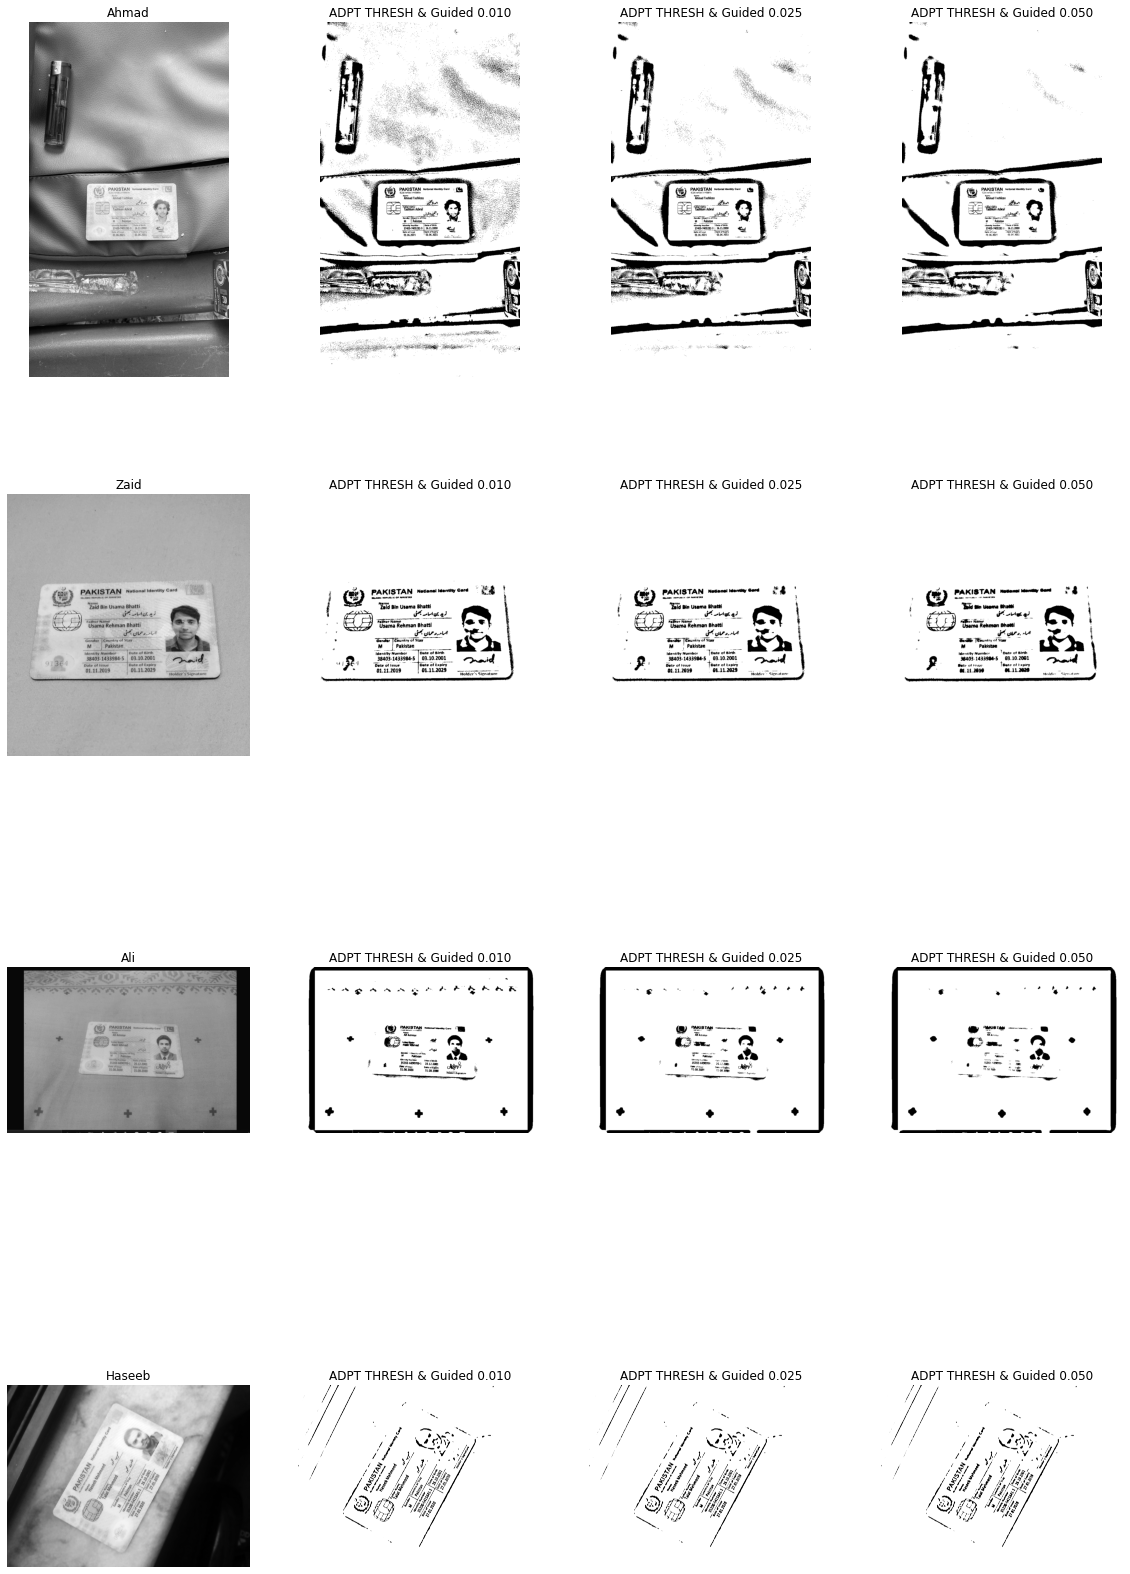

In [281]:
#eps = 0.010
guided1 = img_as_ubyte(test_gf(img1,0.010))
guided2 = img_as_ubyte(test_gf(img2,0.010))
guided3 = img_as_ubyte(test_gf(img3,0.010))
guided4 = img_as_ubyte(test_gf(img4,0.010))

#eps = 0.025
guided5 = img_as_ubyte(test_gf(img1,0.025))
guided6 = img_as_ubyte(test_gf(img2,0.025))
guided7 = img_as_ubyte(test_gf(img3,0.025))
guided8 = img_as_ubyte(test_gf(img4,0.025))

#eps = 0.050
guided9 = img_as_ubyte(test_gf(img1,0.050))
guided10 = img_as_ubyte(test_gf(img2,0.050))
guided11 = img_as_ubyte(test_gf(img3,0.050))
guided12 = img_as_ubyte(test_gf(img4,0.050))

# adaptive thresholding
adp_th1_gf = cv2.adaptiveThreshold(guided1,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,107,9)
adp_th2_gf = cv2.adaptiveThreshold(guided2,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,107,9)
adp_th3_gf = cv2.adaptiveThreshold(guided3,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,107,9)
adp_th4_gf = cv2.adaptiveThreshold(guided4,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,107,9)
adp_th5_gf = cv2.adaptiveThreshold(guided5,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,107,9)
adp_th6_gf = cv2.adaptiveThreshold(guided6,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,107,9)
adp_th7_gf = cv2.adaptiveThreshold(guided7,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,107,9)
adp_th8_gf = cv2.adaptiveThreshold(guided8,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,107,9)
adp_th9_gf = cv2.adaptiveThreshold(guided9,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,107,9)
adp_th10_gf = cv2.adaptiveThreshold(guided10,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,107,9)
adp_th11_gf = cv2.adaptiveThreshold(guided11,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,107,9)
adp_th12_gf = cv2.adaptiveThreshold(guided12,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,107,9)


fig = plt.figure(figsize=(20, 30))
# setting values to rows and column variables
rows = 4
columns = 4
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(img1,'gray')
plt.axis('off')
plt.title("Ahmad")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(adp_th1_gf,'gray')
plt.axis('off')
plt.title("ADPT THRESH & Guided 0.010")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(adp_th5_gf,'gray')
plt.axis('off')
plt.title("ADPT THRESH & Guided 0.025")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(adp_th9_gf,'gray')
plt.axis('off')
plt.title("ADPT THRESH & Guided 0.050")

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 5)
  
# showing image
plt.imshow(img2,'gray')
plt.axis('off')
plt.title("Zaid")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 6)
  
# showing image
plt.imshow(adp_th2_gf,'gray')
plt.axis('off')
plt.title("ADPT THRESH & Guided 0.010")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 7)
  
# showing image
plt.imshow(adp_th6_gf,'gray')
plt.axis('off')
plt.title("ADPT THRESH & Guided 0.025")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 8)
  
# showing image
plt.imshow(adp_th10_gf,'gray')
plt.axis('off')
plt.title("ADPT THRESH & Guided 0.050")

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 9)
  
# showing image
plt.imshow(img3,'gray')
plt.axis('off')
plt.title("Ali")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 10)
  
# showing image
plt.imshow(adp_th3_gf,'gray')
plt.axis('off')
plt.title("ADPT THRESH & Guided 0.010")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 11)
  
# showing image
plt.imshow(adp_th7_gf,'gray')
plt.axis('off')
plt.title("ADPT THRESH & Guided 0.025")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 12)
  
# showing image
plt.imshow(adp_th11_gf,'gray')
plt.axis('off')
plt.title("ADPT THRESH & Guided 0.050")

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 13)
  
# showing image
plt.imshow(img4,'gray')
plt.axis('off')
plt.title("Haseeb")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 14)
  
# showing image
plt.imshow(adp_th4_gf,'gray')
plt.axis('off')
plt.title("ADPT THRESH & Guided 0.010")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 15)
  
# showing image
plt.imshow(adp_th8_gf,'gray')
plt.axis('off')
plt.title("ADPT THRESH & Guided 0.025")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 16)
  
# showing image
plt.imshow(adp_th12_gf,'gray')
plt.axis('off')
plt.title("ADPT THRESH & Guided 0.050")


Text(0.5, 1.0, 'OTSU THRESH & GB')

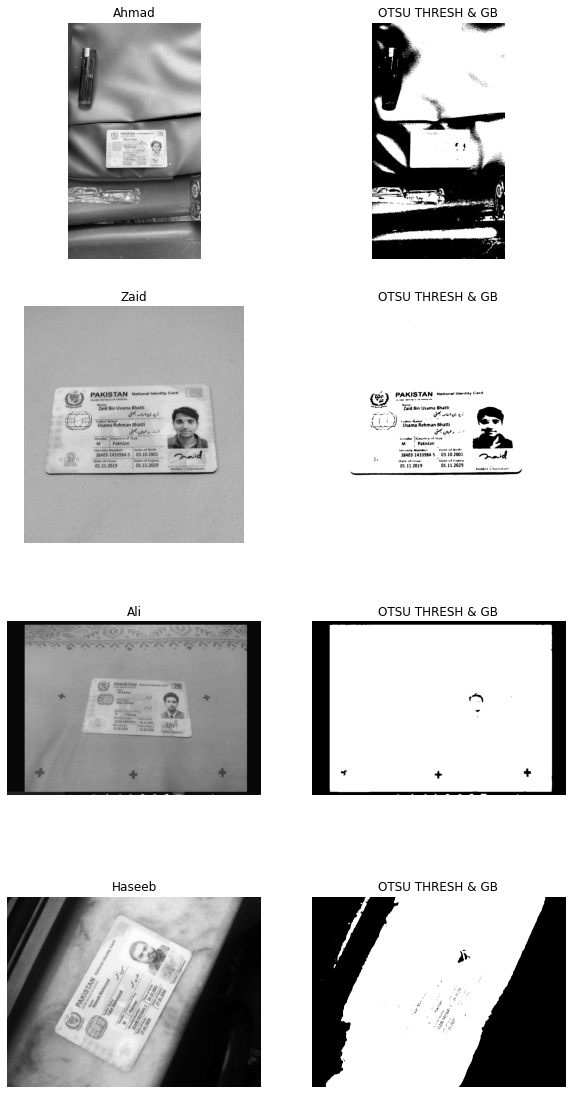

In [244]:
# Otsu's thresholding with Gaussian Blur
blur1 = cv2.GaussianBlur(img1,(5,5),0)
ret1,gb_th1 = cv2.threshold(blur1,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
blur2 = cv2.GaussianBlur(img2,(5,5),0)
ret2,gb_th2= cv2.threshold(blur2,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
blur3 = cv2.GaussianBlur(img3,(5,5),0)
ret3,gb_th3 = cv2.threshold(blur3,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
blur4 = cv2.GaussianBlur(img4,(5,5),0)
ret4,gb_th4 = cv2.threshold(blur4,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)


fig = plt.figure(figsize=(10, 20))
# setting values to rows and column variables
rows = 4
columns = 2
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(img1,'gray')
plt.axis('off')
plt.title("Ahmad")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(gb_th1,'gray')
plt.axis('off')
plt.title("OTSU THRESH & GB")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(img2,'gray')
plt.axis('off')
plt.title("Zaid")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(gb_th2,'gray')
plt.axis('off')
plt.title("OTSU THRESH & GB")

# Adds a subplot at the 5th position
fig.add_subplot(rows, columns, 5)
  
# showing image
plt.imshow(img3,'gray')
plt.axis('off')
plt.title("Ali")
  
# Adds a subplot at the 6th position
fig.add_subplot(rows, columns, 6)
  
# showing image
plt.imshow(gb_th3,'gray')
plt.axis('off')
plt.title("OTSU THRESH & GB")

# Adds a subplot at the 7th position
fig.add_subplot(rows, columns, 7)
  
# showing image
plt.imshow(img4,'gray')
plt.axis('off')
plt.title("Haseeb")
  
# Adds a subplot at the 8th position
fig.add_subplot(rows, columns, 8)
  
# showing image
plt.imshow(gb_th4,'gray')
plt.axis('off')
plt.title("OTSU THRESH & GB")

Text(0.5, 1.0, 'OTSU THRESH')

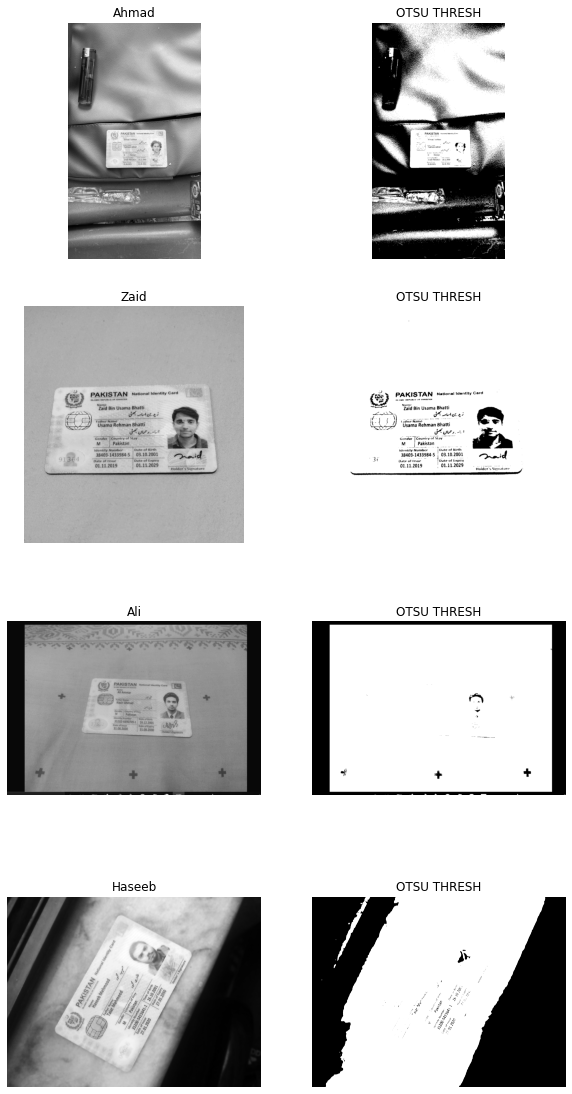

In [245]:
# Otsu's thresholding
ret1,otsu_th1 = cv2.threshold(img1,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret2,otsu_th2 = cv2.threshold(img2,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret3,otsu_th3 = cv2.threshold(img3,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret4,otsu_th4 = cv2.threshold(img4,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)


fig = plt.figure(figsize=(10, 20))
# setting values to rows and column variables
rows = 4
columns = 2
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(img1,'gray')
plt.axis('off')
plt.title("Ahmad")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(otsu_th1,'gray')
plt.axis('off')
plt.title("OTSU THRESH")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(img2,'gray')
plt.axis('off')
plt.title("Zaid")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(otsu_th2,'gray')
plt.axis('off')
plt.title("OTSU THRESH")

# Adds a subplot at the 5th position
fig.add_subplot(rows, columns, 5)
  
# showing image
plt.imshow(img3,'gray')
plt.axis('off')
plt.title("Ali")
  
# Adds a subplot at the 6th position
fig.add_subplot(rows, columns, 6)
  
# showing image
plt.imshow(otsu_th3,'gray')
plt.axis('off')
plt.title("OTSU THRESH")

# Adds a subplot at the 7th position
fig.add_subplot(rows, columns, 7)
  
# showing image
plt.imshow(img4,'gray')
plt.axis('off')
plt.title("Haseeb")
  
# Adds a subplot at the 8th position
fig.add_subplot(rows, columns, 8)
  
# showing image
plt.imshow(otsu_th4,'gray')
plt.axis('off')
plt.title("OTSU THRESH")

In [469]:
kernel_de = np.ones((3, 3), np.uint8)
kernel = np.ones((5, 5), np.uint8)
img_dilation = cv2.dilate(adp_th1_bl, kernel_de, iterations=1)
img_erosion = cv2.erode(img_dilation, kernel_de, iterations=1)

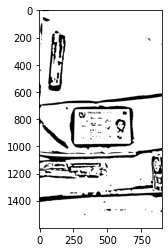

In [470]:
plt.imshow(img_erosion,('gray'))

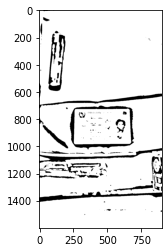

In [471]:
plt.imshow(img_dilation,cmap=plt.get_cmap('gray'))

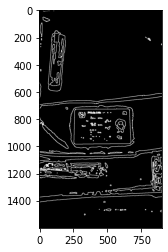

In [472]:
edge_canny = cv2.Canny(img_erosion, 0, 255)
edge_canny = cv2.dilate(edge_canny, None, iterations=1)
plt.imshow(edge_canny,cmap=plt.get_cmap('gray'))

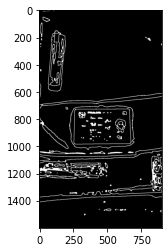

In [473]:
edge_canny = cv2.morphologyEx(edge_canny, cv2.MORPH_CLOSE, kernel)
plt.imshow(edge_canny,('gray'))

7458
50526
110918
17187
9992
2541
2544
195332
8


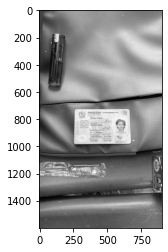

In [480]:
# Apply the Component analysis function
analysis = cv2.connectedComponentsWithStats(edge_canny,
                                            4,
                                            cv2.CV_32S)
(totalLabels, label_ids, values, centroid) = analysis
count = 0
# Initialize a new image to store
# all the output components
output = np.zeros(img1.shape, dtype="uint8")
 
# Loop through each component
for i in range(1, totalLabels):
   
      # Area of the component
    area = values[i, cv2.CC_STAT_AREA]
     
    if (area > 500):
        print(area)
        count+=1
        componentMask = (label_ids == i).astype("uint8") * 255
        output = cv2.bitwise_or(output, componentMask)
 
print(count)
plt.imshow(img1,('gray'))


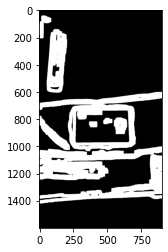

In [481]:
plt.imshow(output,('gray'))

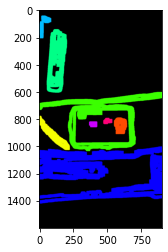

In [482]:
num_labels, labels_im = cv2.connectedComponents(edge_canny)

def imshow_components(labels):
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0

    plt.imshow(labeled_img)

imshow_components(labels_im)

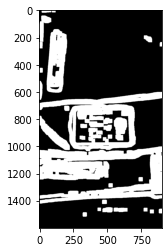

In [477]:
edge_canny = cv2.dilate(edge_canny, None, iterations=10)
plt.imshow(edge_canny,cmap=plt.get_cmap('gray'))

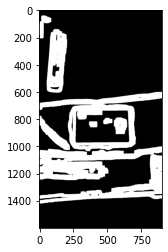

In [478]:
edge_canny = cv2.dilate(output, None, iterations=10)
plt.imshow(edge_canny,cmap=plt.get_cmap('gray'))

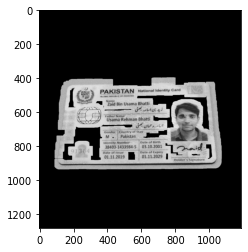

In [381]:
# cnt = sorted(cv2.findContours(edge_canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2], key=cv2.contourArea)[-1]
# mask = np.zeros(img2.shape, dtype='uint8')
# mask = np.copy(grad_x)
# drawn_contours = cv2.drawContours(mask, [cnt], -1, 255, -1)
dst = cv2.bitwise_and(img2, img2, mask=edge_canny)
plt.imshow(dst, 'gray')
plt.show()

In [80]:
edge = getEdges(img_erosion)
# edge = cv2.dilate(cv2.Canny(thresh1, np.min(img), np.max(img)), None)

In [52]:
grad_x = cv2.Sobel(img_erosion, cv2.CV_16S, 1, 0, ksize=3, scale=1, delta=0, borderType=cv2.BORDER_DEFAULT)